# AdventureWorks fösälningsanalys
I denna analys undersöker vi AdventureWroks- databasen för att besvara affärsfrågor som exemplvis:
- Produktkategorier och deras försälning
- Försälningstrender över tid
- Regional försälning

Vi använder SQL för att hämta data och Pyhtonför visualisering och analys.

## Visualisering 1: Antal produkter per kategori
hur många produkter finns i varje kategori?

Tabeller som används:
Production.ProductCategory
Production.ProductSubCategory
Production.Product

Plan:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analysera resultatet

In [10]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt

user = "sa"
password = quote_plus("WM271290!")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = f"mssql+pyodbc://{user}:{password}@{server}/{database}?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
engine = create_engine(connection_string)
 
try: 
    with engine.connect():
        print("Connection to the database was successful.")
except Exception as e:
    print("An error occurred while connecting to the database:", e)


def query_df(sql:str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

Connection to the database was successful.


C:\Users\wendy\AppData\Local\Temp\ipykernel_17096\848119440.py:16: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


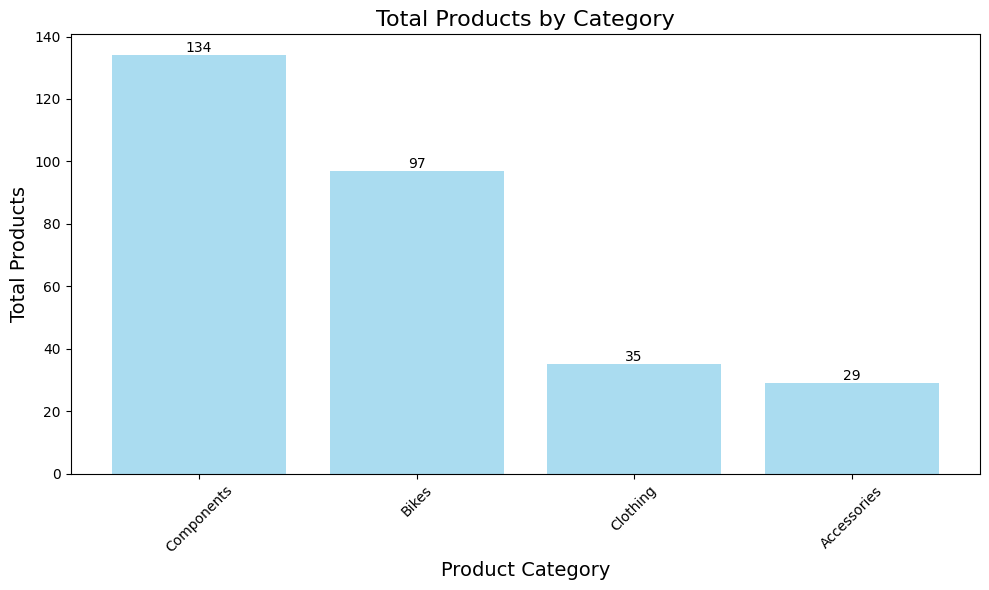

In [11]:
query_vis1 = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS TotalProducts

FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY TotalProducts DESC
"""

df_vis1 = query_df(query_vis1)
df_vis1

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['TotalProducts'], color='skyblue',alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

ax.set_title('Total Products by Category', fontsize=16)
ax.set_xlabel('Product Category', fontsize=14)
ax.set_ylabel('Total Products', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Insikter - antal produkt per kategori

Compoents är störasta kategorin med 134 produkter. Accessories är minst med 29 produkter.
Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.